# 실습 - MobileNet V2 Tensorflow로 구현해보기
이번 실습에서는 Tensorflow Functional API를 이용하여 이미지를 구분하는 Neural Network를 MobileNet V2 구조로 구현해 보는 실습을 진행할 것이다. <br>
그 중에서도 가장 핵심이라고 할 수 있는 Linear bottleneck과 Inverted residuals를 중점적으로 다룰 것이다.

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Add, ReLU, Input, Dense, Activation, Flatten, Conv2D, \
    DepthwiseConv2D, BatchNormalization, GlobalAveragePooling2D, Dropout
from tensorflow.keras.regularizers import l2

`BatchNormalization(axis, momentum, epsilon)` : https://keras.io/api/layers/normalization_layers/batch_normalization/
- axis: Batch normalization이 적용될 axis. 우리는 채널에 대해서 BN을 적용할 것이다. 
- momentum: Moving average에 적용될 momentum 계수
- epsilon: 0으로 나누는 것을 방지하기 위한 작은 수.


`DepthwiseConv2D(kernel_size, strides, padding, use_bias, depthwise_regularizer)` : https://keras.io/api/layers/convolution_layers/depthwise_convolution2d/

## Inverted Residual and Linear Bottleneck

paper: [MobileNetV2](https://openaccess.thecvf.com/content_cvpr_2018/papers/Sandler_MobileNetV2_Inverted_Residuals_CVPR_2018_paper.pdf)
<img src="https://user-images.githubusercontent.com/37704174/112773048-5bbfd400-906f-11eb-8e0c-62558ba0a1a2.PNG" width="500" height="500"/>

<img src="https://user-images.githubusercontent.com/37704174/112772900-5e6df980-906e-11eb-9c02-5310fa51ff43.PNG" width="300" height="300"/> 

- 다음의 API 문서를 참고하자
https://keras.io/api/

### Expansion
  - `expansion != 1`인 <b>경우에만</b> 1x1 convolution을 이용하여 channel의 수를 `expansion`배 만큼 증가시킴
  - `strides=1`, `padding='same'`, `use_bias=False`, `kernel_regularizer=l2(4e-5)`
  - `BatchNormalization`과 ReLU6을 이용
    - BN의 `momentum=0.999`, `epsilon=0.001`
    - ReLU6은 ReLU함수에서 최대값이 6인 함수
    
### Depthwise convolution
  - 3x3 `DepthwiseConv2D` layer를 이용
  - `strides`를 함수 입력으로 받음,  `padding=same`, `use_bias=False`, `depthwise_regularizer=l2(4e-5)`
  - `BatchNormalization`과 ReLU6을 이용
    - 위와 같음
    
    
   
### Linear bottleneck
  - 1x1 convolution으로 channel의 수를 함수 입력으로 받는 `filters`로 줄임
  - `strides=1`, `padding='same'`, `use_bias=False`, `kernel_regularizer=l2(4e-5)`
  - `BatchNormalization`을 이용
    - 위와 같음
  - 'Linear' bottleneck이기 때문에 Activation은 이용하지 않음


### Residual
  - input channel의 수와 `filters`가 같고, `strides`가 1인 경우에 원래 들어왔던 inputs와 Linear bottleneck의 output을 `Add` 해준다



## 위의 설명대로 Inverted residual block을 구현하기

In [6]:
def _inverted_res_block(inputs, expansion, filters, strides):
    x = inputs
    in_chnls = inputs.shape[-1]
    # Expansion
    if expansion != 1:
        x = Conv2D(kernel_size=1, filters=in_chnls * expansion, strides=1, padding='same', use_bias=False, kernel_regularizer=l2(4e-5))(x)
        x = BatchNormalization(momentum=0.999, epsilon=0.001)(x)
        x = ReLU(max_value=6)(x)
        
    # Depthwise convolution
    x = DepthwiseConv2D(kernel_size=3, strides=strides, padding='same', use_bias=False, depthwise_regularizer=l2(4e-5))(x)
    x = BatchNormalization(momentum=0.999, epsilon=0.001)(x)
    x = ReLU(max_value=6)(x)
    
    # Linear bottleneck
    x = Conv2D(kernel_size=1, filters=filters, strides=1, padding='same', use_bias=False, kernel_regularizer=l2(4e-5))(x)
    x = BatchNormalization(momentum=0.999, epsilon=0.001)(x)
    # No activation
    
    # Residual connection
    if in_chnls == filters and strides == 1:
        x = Add()([inputs, x])
        
    return x #return output of layer

### Mobilenet V2 network 구성
위에서 만든 `_inverted_res_block`을 이용하여 MobilenetV2를 구성해 보도록 하자. Network의 구조는 아래 표에 요약되어 있다. <br>
<img src="https://user-images.githubusercontent.com/37704174/112775798-e527d400-9078-11eb-93b1-33cdf2f3e6f7.PNG" width="500" height="500"/>  

- `_inverted_res_block`에서 개수가 1보다 큰 것들은 첫번재 block만 `strides`가 2이고, 나머지는 1임
- Conv2D layer 다음에는 BN과 ReLU6을 이용 (`_inverted_res_block`과 hyperparameter는 같게 설정)
- Dense layer는 `activation='softmax'` 이용

## MobileNetV2 구현

In [20]:
def MobileNetV2(input_shape, classes):
    inputs = Input(shape=input_shape)

    x = Conv2D(filters=32, kernel_size=3, strides=2, padding='same')(inputs)
    x = BatchNormalization(momentum=0.999, epsilon=0.001)(x)
    x = ReLU(max_value=6)(x)
    
    ###### inverted residual blocks  ##### 
    x = _inverted_res_block(inputs = x, expansion = 1, filters = 16, strides = 1)
    
    x = _inverted_res_block(inputs = x, expansion = 6, filters = 24, strides = 2)
    x = _inverted_res_block(inputs = x, expansion = 6, filters = 24, strides = 1)
    
    x = _inverted_res_block(inputs = x, expansion = 6, filters = 32, strides = 2)
    x = _inverted_res_block(inputs = x, expansion = 6, filters = 32, strides = 1)
    x = _inverted_res_block(inputs = x, expansion = 6, filters = 32, strides = 1)
    
    x = _inverted_res_block(inputs = x, expansion = 6, filters = 64, strides = 2)
    x = _inverted_res_block(inputs = x, expansion = 6, filters = 64, strides = 1)
    x = _inverted_res_block(inputs = x, expansion = 6, filters = 64, strides = 1)
    x = _inverted_res_block(inputs = x, expansion = 6, filters = 64, strides = 1)
    
    x = _inverted_res_block(inputs = x, expansion = 6, filters = 96, strides = 1)
    x = _inverted_res_block(inputs = x, expansion = 6, filters = 96, strides = 1)
    x = _inverted_res_block(inputs = x, expansion = 6, filters = 96, strides = 1)
    
    x = _inverted_res_block(inputs = x, expansion = 6, filters = 160, strides = 2)
    x = _inverted_res_block(inputs = x, expansion = 6, filters = 160, strides = 1)
    x = _inverted_res_block(inputs = x, expansion = 6, filters = 160, strides = 1)
    
    x = _inverted_res_block(inputs = x, expansion = 6, filters = 320, strides = 1)
    ###### 빈칸 끝 #####
    x = Conv2D(kernel_size=1, filters=1280, strides=1, padding='same')(x)
    x = BatchNormalization(momentum=0.999, epsilon=0.001)(x)
    x = ReLU(max_value=6)(x)
    
    # global average pooling
    x = GlobalAveragePooling2D()(x)
    
    
    # FC layer
    outputs = Dense(classes, activation='softmax')(x)
    
    return Model(inputs=inputs, outputs=outputs)

In [19]:
model = MobileNetV2(input_shape=(32,32,3), classes=10)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_114 (Conv2D)             (None, 16, 16, 32)   896         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_170 (BatchN (None, 16, 16, 32)   128         conv2d_114[0][0]                 
__________________________________________________________________________________________________
re_lu_114 (ReLU)                (None, 16, 16, 32)   0           batch_normalization_170[0][0]    
____________________________________________________________________________________________

## Cifar-10으로 테스트 
- 우리가 만든 MobileNetV2을 사용해서 Cifar-10 을 학습시켜보자

In [9]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

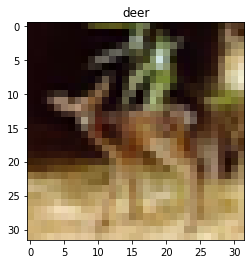

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
i = np.random.randint(len(x_train))
names = {0:'airplane', 1:'automobile', 2:'bird', 3:'cat', 4:'deer', 5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'}
plt.title(names[y_train[i][0]])
plt.imshow(x_train[i])

In [11]:
indices = np.random.randint(low=0, high=len(x_train), size=5000)
x_train, y_train = x_train[indices], y_train[indices]

## 모델 컴파일 및 학습

In [12]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=['accuracy'])

In [13]:
model.fit(x=x_train, y=y_train, batch_size=32, epochs=5, shuffle=True)

Epoch 1/5
157/157 [==============================] - 18s 55ms/step - loss: 3.1740 - accuracy: 0.1398
Epoch 2/5
157/157 [==============================] - 6s 40ms/step - loss: 2.5852 - accuracy: 0.1934
Epoch 3/5
157/157 [==============================] - 10s 61ms/step - loss: 2.4668 - accuracy: 0.2294
Epoch 4/5
157/157 [==============================] - 11s 69ms/step - loss: 2.3113 - accuracy: 0.2768
Epoch 5/5
157/157 [==============================] - 12s 79ms/step - loss: 2.2525 - accuracy: 0.2814


# 과제: MobileNetV2 변형해 보기

## Due: 10/6(수) 15:29 (수업 시작 전)
paper:[MobileNetV3](https://openaccess.thecvf.com/content_ICCV_2019/papers/Howard_Searching_for_MobileNetV3_ICCV_2019_paper.pdf)  

이번 과제에서는 MobileNetV3에서 추가된 내용 중 일부를 반영해 볼 것이다. MobilenetV3에서는 모델의 마지막 부분에 아래 그림과 같은 변화가 있었는데, 요약하자면
* Average pooling 앞의 1x1 Convolution layer와 Average pooling layer의 순서를 바꾸어 줌으로써 Computation은 줄이면서 정보의 손실은 최소화하였다.
* 위 변화가 일어나게 됨으로써 그 이전 Inverted residual layer에서 projection/filtering을 해 줄 필요가 없어졌다. 따라서 마지막 Inverted residual layer의 Expansion 이후 바로 Average pooling이 오게 된다.
* 아래 그림을 보면 더 이해가 쉬울 것이다.
<img src="https://user-images.githubusercontent.com/37704174/112775642-734f8a80-9078-11eb-9bc1-a860a1fea407.PNG" width="700" height="700"/> 
* 마지막 Inverted residual layer는 Original last stage 그림에서 맨 앞 세개이다.


<br>
위 내용을 참조하여 Network의 마지막 부분을 변형한 MobileNetV2plus를 구성하라. 위 그림상의 H-swish는 고려하지 않아도 된다.
<img src="https://user-images.githubusercontent.com/37704174/112777027-1229b600-907c-11eb-9f89-a7b61c0843be.PNG" width="700" height="700"/>  

- **채점기준**
  - 위의 변경 사항 반영하기
    - MobileNetV2에서 마지막 inverted residual block 및 뒷부분을 고치면 됨
    - Average pooling의 output의 가로 세로는 1임
  - test accuracy **80%** 이상
    - BatchNormalization, Activation, Dropout, Regularization, Weight initialization 등 자유롭게 수정, 추가, 제거 가능
    - `strides` 수정 가능
    - 나머지는 그대로


## 사용할 모듈 import

In [ ]:
import tensorflow as tf


## Inverted residual block

- 실습 때 한 것과 동일 

## MobileNetV2 변형 구현

In [ ]:
def MobileNetV2plus(input_shape, classes):
    inputs = Input(shape=input_shape)
    
    ### YOUR CODE HERE ###
    
    outputs = Dense(...)(x)
                                    
    return Model(inputs=inputs, outputs=outputs)

In [ ]:
my_mobilenet = MobileNetV2plus((32,32,3),classes=10)

## Training data

- keras dataset 혹은 tensorflow dataset 이용
- train data를 9:1로 나눠서 validation data로 이용

In [ ]:
from tensorflow.keras.datasets import cifar10
#Load data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

#Split train set into train/valid set
from sklearn import model_selection
x_train, x_valid, y_train, y_valid = model_selection.train_test_split(x_train, y_train,test_size=0.1)

## Data preprocessing
자유롭게 전처리

## Model compile
loss function, optimizer 설정

In [ ]:
my_mobilenet.compile(loss=
                     optimizer=
                     metrics=['accuracy'])

## 추가 작업
learning rate, data augmentation, callback 등..

In [ ]:
callbacks = []
callbacks.append(tf.keras.callbacks. ...)

## Model training
hyperparameter를 적절히 설정한다. (epochs 등..)

In [ ]:
history = my_mobilenet.fit(x_train, y_train, batch_size=, epochs=,
                           callbacks=callbacks,
                           validation_data=(x_valid, y_valid))

## 참고용
조교가 학습한 모델의 validation accuracy를 그래프로 나타내 보았다.

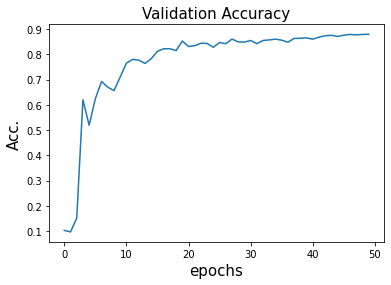

In [63]:
import matplotlib.pyplot as plt

plt.plot(history.history['val_accuracy'])
plt.title('Validation Accuracy', fontsize=15)
plt.xlabel('epochs', fontsize=15)
plt.ylabel('Acc.', fontsize=15)

plt.show()

## Test Accuracy

test accuracy 측정 결과 **80% 이상**이 나와야 한다.

In [64]:
my_mobilenet.evaluate(x_test,y_test)

313/313 [==============================] - 4s 10ms/step - loss: 0.7716 - accuracy: 0.8799


[0.7716487050056458, 0.8798999786376953]